# ==============================================
# Bitcoin Price Prediction - Model Evaluation & Fine Tuning
# ==============================================

In [4]:
# -------------------------------
# 1.  Required Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import joblib

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# -------------------------------
# 2. Loading Preprocessed Dataset
# -------------------------------
#Here we need to use feature engineered data, refined data 
bitcoin_df = pd.read_csv('../data/bitcoin.csv', parse_dates=['Date'], dayfirst=True)

In [7]:
bitcoin_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [8]:
# Redo feature engineering (same snippet that I have done in bitcoin price prediction file)
bitcoin_df['Price_Change'] = bitcoin_df['Close'] - bitcoin_df['Open']
bitcoin_df['Daily_Return'] = bitcoin_df['Close'].pct_change()
bitcoin_df['MA_5'] = bitcoin_df['Close'].rolling(window=5).mean()
bitcoin_df['MA_10'] = bitcoin_df['Close'].rolling(window=10).mean()
bitcoin_df.dropna(inplace=True)

In [9]:
# -------------------------------
# 3. Feature Selection
# -------------------------------
features = ['Open', 'High', 'Low', 'Volume', 'Price_Change', 'Daily_Return', 'MA_5', 'MA_10']
target = 'Close'

X = bitcoin_df[features]
y = bitcoin_df[target]

In [10]:
# -------------------------------
# 4. Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# -------------------------------
# 5. Model 1: Linear Regression
# -------------------------------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [12]:
lr_model

LinearRegression()

In [13]:
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [14]:
print("\nLinear Regression:")
print(f"MSE: {mse_lr:.2f}, R2 Score: {r2_lr:.4f}")


Linear Regression:
MSE: 0.00, R2 Score: 1.0000


In [15]:
# -------------------------------
# 6. Model 2: Random Forest (Base Model)
# -------------------------------
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_rf_base = rf_base.predict(X_test)


In [16]:
mse_rf_base = mean_squared_error(y_test, y_pred_rf_base)
r2_rf_base = r2_score(y_test, y_pred_rf_base)

In [17]:

print("\nRandom Forest (Base Model):")
print(f"MSE: {mse_rf_base:.2f}, R2 Score: {r2_rf_base:.4f}")


Random Forest (Base Model):
MSE: 99026.18, R2 Score: 0.9996


In [18]:
# -------------------------------
# 7. Hyperparameter Tuning (GridSearchCV)
# -------------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

print("\nPerforming Grid Search...")
grid_search.fit(X_train, y_train)

print("\nBest Parameters:")
print(grid_search.best_params_)


Performing Grid Search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [19]:
# -------------------------------
# 8. Best Model Evaluation
# -------------------------------
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nBest Random Forest Model:")
print(f"MSE: {mse_best:.2f}, R2 Score: {r2_best:.4f}")


Best Random Forest Model:
MSE: 99026.18, R2 Score: 0.9996


In [20]:
# -------------------------------
# 9. Cross-Validation (Robust Evaluation)
# -------------------------------
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print("\nCross-Validation R2 Scores:")
print(cv_scores)
print(f"Average R2 Score: {cv_scores.mean():.4f}")


Cross-Validation R2 Scores:
[-2.07688774  0.82360208  0.99281066  0.99409045 -1.66046365]
Average R2 Score: -0.1854


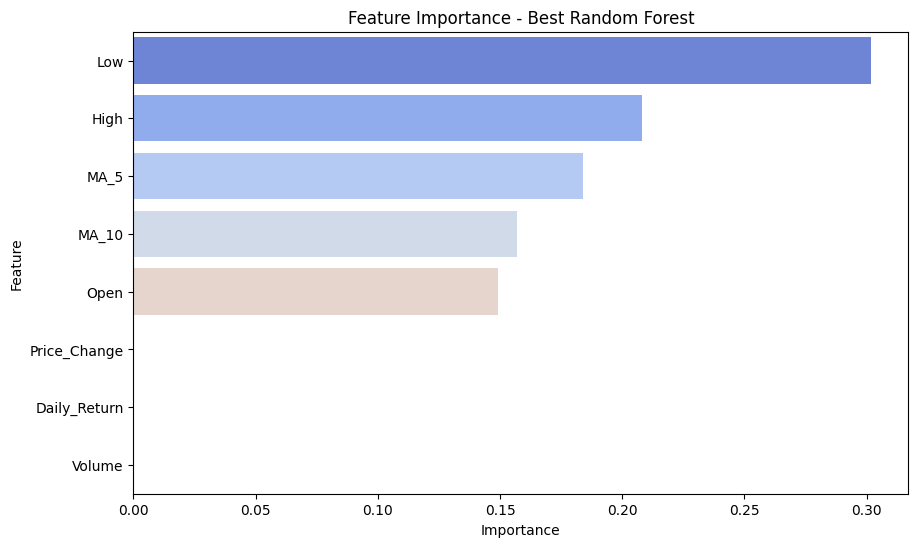

In [21]:
# -------------------------------
# 10. Feature Importance Plot
# -------------------------------
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='coolwarm')
plt.title('Feature Importance - Best Random Forest')
plt.show()

In [22]:
# -------------------------------
# 11. Save Best Model
# -------------------------------
joblib.dump(best_rf, '../models/best_bitcoin_rf_model.pkl')
print("\nBest tuned model saved as best_bitcoin_rf_model.pkl")



Best tuned model saved as best_bitcoin_rf_model.pkl


### ==============================================
# Summary of Steps:
#### ==============================================
# 1. Loaded data and applied feature engineering
# 2. Trained Linear Regression and base Random Forest
# 3. Used GridSearchCV to fine-tune Random Forest hyperparameters
# 4. Evaluated the best model using MSE, R2, and cross-validation
# 5. Plotted feature importance and saved the best model for deployment